# Analysis and visualization of M&M taste test

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load participant data

In [2]:
participants = pd.read_csv('data/participants.txt',sep='\t')
participants.head()

,participant_id,continent_of_origin
0,1,North America
1,2,Europe
2,3,North America
3,4,Europe
4,5,Europe


In [3]:
# mapping of participant to continent
p2c = dict(participants.values)

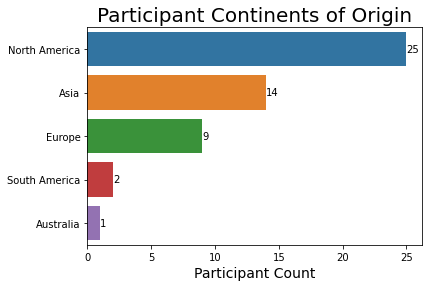

In [4]:
# plot the distriubtion of particpants across continents
con_counts = participants['continent_of_origin'].value_counts()

ax = sns.barplot(y=con_counts.keys(),x=con_counts.values)
ax.bar_label(ax.containers[0])
plt.xlabel("Participant Count", fontsize=14)
plt.title("Participant Continents of Origin",fontsize=20)
plt.show()

In [215]:
# separate counts by those collected in Denmark vs US
participants['data_collection'] = participants['participant_id'].apply(
    lambda x: "collected in Lyngby" if x <=14 else "collected in Seattle"
)
participants['continent_adj'] = participants['continent_of_origin'].apply(lambda x: 'Aus/SA' if x in ['Australia','South America'] else x)

participants.head()

,participant_id,continent_of_origin,data_collection,continent_adj
0,1,North America,collected in Lyngby,North America
1,2,Europe,collected in Lyngby,Europe
2,3,North America,collected in Lyngby,North America
3,4,Europe,collected in Lyngby,Europe
4,5,Europe,collected in Lyngby,Europe


In [216]:
alt.Chart(participants).mark_bar().encode(
    alt.Y("continent_of_origin:N"),
    alt.X("count(continent_of_origin)"),
    alt.Color("continent_of_origin:N"),
    alt.Row("data_collection:N"),
)

alt.Chart(...)

In [634]:
bars = alt.Chart(participants).mark_bar().encode(
    x=alt.X('count(continent_of_origin)',
            title="Count of participants ",
            axis=alt.Axis(titleFontSize=12)),
    y=alt.Y('continent_of_origin',title="",sort='-x',axis=alt.Axis(labelFontSize=14)),
    color=alt.Color('data_collection:N',title="",
                    legend=alt.Legend(
                        orient='none',
                        legendX=180, legendY=115,
                        direction='vertical',
                        titleAnchor='middle',
                        strokeColor='black',
                        padding=2)
                   ).scale(scheme="tableau20"),    
    tooltip=['continent_of_origin','data_collection','count(continent_of_origin)']
).properties(width=300,height=150,title="Distribution of participant continent of origin")


text_indiv = alt.Chart(participants).mark_text(dx=1,align='left',size=12).encode(
     x=alt.X('count(continent_of_origin)').stack('zero'),
     y=alt.Y('continent_of_origin',title="",sort='-x',axis=alt.Axis(labelFontSize=14)),
    detail='data_collection:N',
    color='data_collection',
    text=alt.Text('count(continent_of_origin):Q')
)

chart = bars + text_indiv
chart.save('figs/participant_sampling.html')
chart

alt.LayerChart(...)

## Load M&M id data

In [8]:
# load M&M id data
mnms = pd.read_csv('data/mnm.txt',sep='\t')
mnms.head()

,mnm_id,origin
0,1,USA
1,2,Denmark


In [9]:
# mapping of mnm id to origin
m2o = dict(mnms.values)
m2o

{1: 'USA', 2: 'Denmark'}

## Load taste experiment data

In [10]:
# load taste experiemnt data
df = pd.read_csv('data/taste_data.txt',sep='\t').fillna("")
df.head()

,participant_id,mnm_id,mnm_color,taste_response,notes
0,1,2,green,normal,
1,1,1,orange,bad,
2,1,1,blue,normal,
3,1,2,brown,normal,
4,1,1,yellow,bad,


In [11]:
# add continent and mnm ID column
df['continent'] = df['participant_id'].apply(lambda x: p2c[x])
df['mnm_origin'] = df['mnm_id'].apply(lambda x: m2o[x])
df.head()

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin
0,1,2,green,normal,,North America,Denmark
1,1,1,orange,bad,,North America,USA
2,1,1,blue,normal,,North America,USA
3,1,2,brown,normal,,North America,Denmark
4,1,1,yellow,bad,,North America,USA


## What is the overall taste evalution of M&Ms purchased in Denmark vs purchased in the USA?
For now, we disregard participant continent of origin and look at the collective taste response

In [22]:
taste_order = ['bad','normal','good']

alt.Chart(df).mark_bar(size=90).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",
            axis=alt.Axis(labelAngle=0,labelFontSize=14,titleFontSize=14)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    tooltip=['taste_response','count(taste_response)']
).properties(width=210)

alt.Chart(...)

Overall, more participants reported European-sourced M&M's as tasting "good," but also as tasting "bad". USA-sourced M&M's were more commonly reported to taste "normal" than either "good" or "bad."

### Combine Australia/South America groups
To help condense the charts and "preserve privacy"

In [23]:
order=None

In [20]:
df['continent_adj'] = df['continent'].apply(lambda x: 'Aus/SA' if x in ['Australia','South America'] else x)
df

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin,continent_adj
0,1,2,green,normal,,North America,Denmark,North America
1,1,1,orange,bad,,North America,USA,North America
2,1,1,blue,normal,,North America,USA,North America
3,1,2,brown,normal,,North America,Denmark,North America
4,1,1,yellow,bad,,North America,USA,North America
...,...,...,...,...,...,...,...,...
505,52,1,red,good,,Europe,USA,Europe
506,52,2,red,bad,,Europe,Denmark,Europe
507,52,1,brown,bad,,Europe,USA,Europe
508,52,2,brown,good,,Europe,Denmark,Europe


## Do participants from different continents percieve M&M's differently?

In [24]:
cont_perc = alt.Chart(df).mark_bar(size=40).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",
            axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,
                    title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('continent_adj:N',title='',
                      header=alt.Header(labelFontSize=18),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(
    width=100,
    height=180
)

cont_perc

alt.Chart(...)

Almost 50% of the time a European participant evaluated a USA-sourced M&M, they reported it tasting "bad."

Almost 50% of the time a North American participant evaluated a Denmark-sourced M&M, they reported it tasting "good."

### Selectable legend to filter taste response group

In [26]:
selection = alt.selection_multi(fields=['taste_response'], bind='legend')

cont_count = alt.Chart(df).mark_bar(size=40).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",
            axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Count of Responses"),#.stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste"
                   ).scale(scheme='brownbluegreen',
                           domain=taste_order),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('continent_adj:N',title='',
                      header=alt.Header(labelFontSize=18),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(
    width=100,
    height=180
).add_selection(
    selection
).transform_filter(
    selection
)
cont_count

alt.Chart(...)

In [27]:
cont_comb = alt.vconcat(cont_count,cont_perc)
cont_comb

alt.VConcatChart(...)

In [29]:
df_filt = df[df['continent_adj'] != 'Aus/SA']
order = ['bad','normal','good']

cont_mnm_grouped = alt.Chart(df_filt).mark_bar(size=70).encode(
    x=alt.X('continent_adj:N',title="Participant continent",
            axis=alt.Axis(labelAngle=0,labelFontSize=14)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,
                    title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',
                      header=alt.Header(labelFontSize=18,titleFontSize=14),
                      sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(width=250, height=200)
cont_mnm_grouped

alt.Chart(...)

### Show distribution of taste response counts of each continent

In [391]:
w = 60
h = 80
sp = 4

eu = alt.Chart(df[df['continent_adj']=='Europe'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=taste_order, # not sure why this sort is needed but it is
          axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N",title='M&M Origin').scale(scheme="set1"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='Europe',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

na = alt.Chart(df[df['continent_adj']=='North America'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=taste_order, # not sure why this sort is needed but it is
          axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='North America',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

asi = alt.Chart(df[df['continent_adj']=='Asia'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=taste_order), # not sure why this sort is needed but it is
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='Asia',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

ausa = alt.Chart(df[df['continent_adj']=='Aus/SA'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title=''), # not sure why this sort is NOT needed when the others are?
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=taste_order,spacing=sp,
               header=alt.Header(labelFontSize=14,title='Aus/SA',titleFontSize=20)),
    order=alt.Order('column_taste_response_sort_index:Q')
).properties(
    width=w,
    height=h,
)

euna = alt.hconcat(eu,na)
aa = alt.hconcat(asi,ausa)
alt.vconcat(euna,aa
).configure_axis(
    grid=False,
)

alt.VConcatChart(...)

## contingency table?

In [35]:
table_count = df.groupby(['mnm_origin','continent_adj'])['taste_response'].value_counts()
table_perc = df.groupby(['mnm_origin','continent_adj'])['taste_response'].value_counts(normalize=True)
table = pd.concat([table_count,table_perc], axis=1, keys=['count', 'percentage'])

In [36]:
table

count  percentage
mnm_origin continent_adj taste_response                   
Denmark    Asia          good               27    0.385714
                         bad                24    0.342857
                         normal             19    0.271429
           Aus/SA        normal             11    0.733333
                         bad                 4    0.266667
           Europe        normal             17    0.377778
                         good               16    0.355556
                         bad                12    0.266667
           North America good               57    0.456000
                         normal             37    0.296000
                         bad                31    0.248000
USA        Asia          normal             30    0.428571
                         good               21    0.300000
                         bad                19    0.271429
           Aus/SA        normal             10    0.666667
                         good                3    0.200000
                         bad                 2    0.133333
           Europe        bad                22    0.488889
                         normal             15    0.333333
                         good                8    0.177778
           North America normal             60    0.480000
                         good               48    0.384000
                         bad                17    0.136000

In [45]:
#table.reset_index()
table2 = pd.DataFrame()
table2['mnm_origin'] = table.index.get_level_values(0)
table2['continent'] = table.index.get_level_values(1)
table2['taste_response'] = table.index.get_level_values(2)
table2['count'] = table['count'].values
table2['percentage'] = table['percentage'].values
table2

,mnm_origin,continent,taste_response,count,percentage
0,Denmark,Asia,good,27,0.385714
1,Denmark,Asia,bad,24,0.342857
2,Denmark,Asia,normal,19,0.271429
3,Denmark,Aus/SA,normal,11,0.733333
4,Denmark,Aus/SA,bad,4,0.266667
5,Denmark,Europe,normal,17,0.377778
6,Denmark,Europe,good,16,0.355556
7,Denmark,Europe,bad,12,0.266667
8,Denmark,North America,good,57,0.456000
9,Denmark,North America,normal,37,0.296000


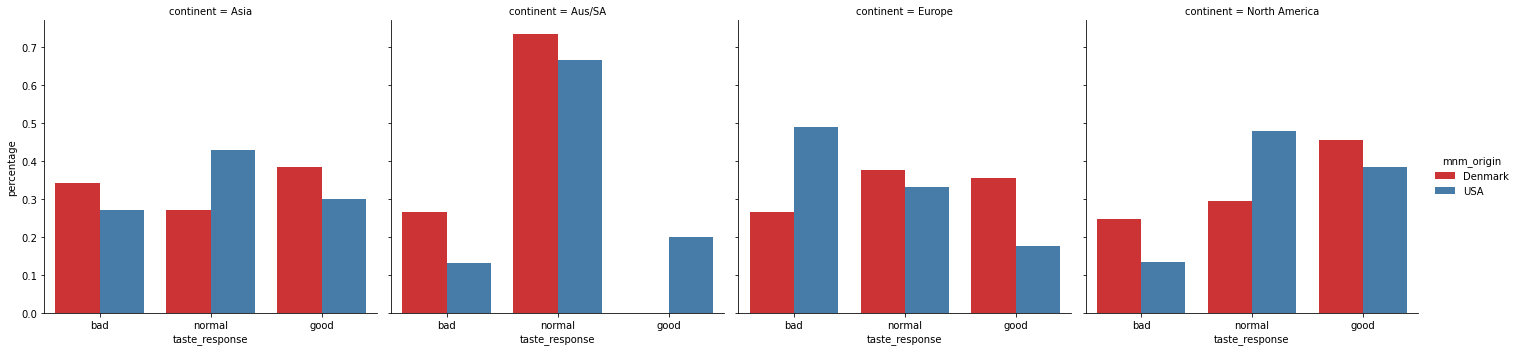

In [393]:
sns.catplot(data=table2, x='taste_response',y='percentage',
            hue='mnm_origin',col="continent",kind='bar',order=order,palette='Set1')

#### Other chart variants - not used

In [52]:
# alt.Chart(df).mark_bar(size=25).encode(
#     x=alt.X('taste_response:N',title="M&M Origin",sort=taste_order,
#             axis=alt.Axis(labelAngle=0,labelFontSize=10)),
#     y=alt.Y('count(mnm_origin)',title=""),
#     color=alt.Color('mnm_origin:N',title="origin"),
#     column=alt.Column('continent_adj:N',title='Continent',header=alt.Header(labelFontSize=10)),
# ).properties(width=105,height=75)

In [51]:
# alt.Chart(df).mark_bar().encode(
#     alt.Y("count(taste_response):N"),#stack=False),
#     alt.X("taste_response",sort=taste_order),
#     alt.Color("mnm_origin:N"),
#     alt.Column("continent_adj:N"),
#     alt.Row('mnm_origin')
# ).properties(height=100)

In [50]:
# alt.Chart(table2).mark_bar().encode(
#     alt.Y("percentage:Q"),#stack=False),
#     alt.X("taste_response",sort=order),
#     alt.Color("mnm_origin:N"),
#     alt.Column("continent:N"),
#     alt.Row('mnm_origin')
# ).properties(height=100)

In [49]:
# alt.Chart(df).mark_bar(size=25).encode(
#     alt.Y("count(taste_response):N",title="Count"),
#     alt.X("mnm_origin",sort=order,),
#     alt.Color("mnm_origin:N"),
#     alt.Column("taste_response:N",sort=order,spacing=1,header=alt.Header(labelFontSize=14)),
#     alt.Row('continent_adj',title='',sort='descending')
# ).properties(
#     width=60,
#     height=50,
# ).configure_axis(
#     grid=False,
# ).configure_view(
#     strokeOpacity=0.4
# )

## Is there a difference in taste reponse to M&M's of different colors?

In [30]:
alt.Chart(df).mark_bar(size=35).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_color:N',title='',header=alt.Header(labelFontSize=18))
).properties(width=80)

alt.Chart(...)

In [31]:
alt.Chart(df).mark_bar(size=25).encode(
    x=alt.X('mnm_color:N',title="M&M color",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',header=alt.Header(labelFontSize=10))
).properties(width=190)

alt.Chart(...)

### Sampling distribution of M&Ms of different colors

In [32]:
alt.Chart(df).mark_bar(size=25).encode(
    x=alt.X('mnm_color:N',title="M&M color",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses"),
    color=alt.Color('taste_response:N',sort=order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',header=alt.Header(labelFontSize=10)),
    tooltip=['taste_response','count(taste_response)']
).properties(width=190)

alt.Chart(...)

In [33]:
mnm_domain = ['blue','brown','green','orange','red','yellow']
mnm_range = ['#055db5','#603a34','#31ac55','#f26f22','#b11224','#e8ca07']
   
alt.Chart(df).mark_bar(size=30).encode(
    x=alt.X('mnm_color:N',title="M&M color",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(mnm_color)',title="Count of M&Ms sampled"),
    color=alt.Color('mnm_color:N',legend=None).scale(domain=mnm_domain,range=mnm_range),
    #order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',header=alt.Header(labelFontSize=14,titleFontSize=14)),
    tooltip=['mnm_color','count(mnm_color)']
).properties(width=210,height=200)

alt.Chart(...)

Most M&M colors were sampled fairly evenly, however there appears to be a skew towards an increased frequency of Blue M&M samples when experimenters drew from the USA-sourced M&M bag.

In [34]:
alt.Chart(df).mark_bar(size=25).encode(
    x=alt.X('mnm_origin:N',title="M&M Origin",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="").stack("normalize"),
    color=alt.Color('taste_response:N',sort=order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_color:N',title='M&M Color',header=alt.Header(labelFontSize=10)),
    row=alt.Row('continent_adj:N',title='Percent of Responses',sort='descending'),
    tooltip=[alt.Tooltip('continent_adj',title="Participant continent"),'taste_response','count(taste_response)']
).properties(width=75,height=75)

alt.Chart(...)

## Chi-squared test for distribution differences

In [83]:
from scipy.stats import chi2_contingency
 
# # defining the table
# data = [[207, 282, 241], [234, 242, 232]]
# stat, p, dof, expected = chi2_contingency(data)
 
# # interpret p-value
# alpha = 0.05
# print("p value is " + str(p))
# if p <= alpha:
#     print('Dependent (reject H0)')
# else:
#     print('Independent (H0 holds true)')

In [480]:
# Chi squared test on all participant data

contingency_table = table2.groupby(['mnm_origin','taste_response']
                                 )['count'].aggregate('sum').unstack()
display(contingency_table)
print(contingency_table.values)

stat, p, dof, expected = chi2_contingency(contingency_table.values)

print(f"stat: {stat} | p: {p} | degfree: {dof}")
print("expectation table:")
display(expected)

# interpret p-value
compare_string = f"\n* RESULT *\nComparing all participants from on their evaluation of M&M's from USA vs Denmark, we find them statistically "
alpha = 0.05
if p <= alpha:
    print(compare_string + f'Dependent (reject H0, {p:.3E} <= {alpha})')
else:
    print(compare_string + f'Independent (H0 holds true, {p:.3f} > {alpha})')

print("\n___________________________")

taste_response,bad,good,normal
mnm_origin,,,
Denmark,71,100,84
USA,60,80,115


[[ 71 100  84]
 [ 60  80 115]]
stat: 7.9750320730028434 | p: 0.01854572385402023 | degfree: 2
expectation table:


array([[65.5, 90. , 99.5],
       [65.5, 90. , 99.5]])


* RESULT *
Comparing all participants from on their evaluation of M&M's from USA vs Denmark, we find them statistically Dependent (reject H0, 1.855E-02 <= 0.05)

___________________________


In [481]:
# achieve same contingency table but with less indexin reseting...?
subt = table2[(table2['mnm_origin']=="USA") & 
               (table2['continent'].isin(["Europe","North America"]))]

t1 = subt.groupby(['continent','taste_response'])['count'].aggregate('sum').unstack()
t2 = subt.pivot(index=['continent','mnm_origin'],
                 columns=['taste_response']
                ).fillna(0)['count'].reset_index()#,columns='count')#['count'].aggregate('mean').unstack()
display(t1)
display(t2)

taste_response,bad,good,normal
continent,,,
Europe,22,8,15
North America,17,48,60


taste_response,continent,mnm_origin,bad,good,normal
0,Europe,USA,22,8,15
1,North America,USA,17,48,60


In [486]:
def chi_same_mnm_compare_continents(cont_table, mnm,groups):
    '''
    Perform a chi-squared analysis on two continent groups to 
    detect a difference in their feelings about a specific M&M origin
    
    For example: 
    Group A and B have a signifincantly different taste repsonse to M&M X.
    '''
    print("\n___________________________")
    print(f"Analyzing {groups} groups on M&M's from {mnm}")
    
    sub_table = cont_table[(cont_table['mnm_origin']==mnm) & 
               (cont_table['continent'].isin(groups))]

    # origin.groupby(['label', 'type'])['value'].aggregate('mean').unstack()
    # the aggregate doesn't do anything... can I remove and still use unstack?
    sub_table = sub_table.groupby(['continent','taste_response']
                                 )['count'].aggregate('sum').unstack()
    display(sub_table)
    
    stat, p, dof, expected = chi2_contingency(sub_table.values)
    
    print(f"stat: {stat} | p: {p} | degfree: {dof}")
    print("expectation table:")
    display(expected)

    # interpret p-value
    compare_string = f"\n* RESULT *\nComparing participants from {groups} on their evaluation of M&M's from {mnm}, we find them statistically "
    alpha = 0.05
    if p <= alpha:
        print(compare_string + f'Dependent (reject H0, {p:.3E} <= {alpha})')
    else:
        print(compare_string + f'Independent (H0 holds true, {p:.3f} > {alpha})')
        
    print("\n___________________________")


### Loop through pairs of continent groupings and compare their taste responses for a specific M&M

In [485]:
mnms = ['Denmark','USA']
groups = [
    ("Europe","North America"),
    ("Europe","Asia"),
    ("North America","Asia"),
]

for m in mnms:
    for (c1,c2) in groups:
        chi_same_mnm_compare_continents(table2,m,[c1,c2])


___________________________
Analyzing ['Europe', 'North America'] groups on M&M's from Denmark


taste_response,bad,good,normal
continent,,,
Europe,12.0,16.0,17.0
North America,31.0,57.0,37.0


stat: 1.5196193907262532 | p: 0.46775543456848623 | degfree: 2
expectation table:


array([[11.38235294, 19.32352941, 14.29411765],
       [31.61764706, 53.67647059, 39.70588235]])


* RESULT *
Comparing participants from ['Europe', 'North America'] on their evaluation of M&M's from Denmark, we find them statistically Independent (H0 holds true, 0.468 > 0.05)

___________________________

___________________________
Analyzing ['Europe', 'Asia'] groups on M&M's from Denmark


taste_response,bad,good,normal
continent,,,
Asia,24.0,27.0,19.0
Europe,12.0,16.0,17.0


stat: 1.5642047085845534 | p: 0.45744329180308263 | degfree: 2
expectation table:


array([[21.91304348, 26.17391304, 21.91304348],
       [14.08695652, 16.82608696, 14.08695652]])


* RESULT *
Comparing participants from ['Europe', 'Asia'] on their evaluation of M&M's from Denmark, we find them statistically Independent (H0 holds true, 0.457 > 0.05)

___________________________

___________________________
Analyzing ['North America', 'Asia'] groups on M&M's from Denmark


taste_response,bad,good,normal
continent,,,
Asia,24.0,27.0,19.0
North America,31.0,57.0,37.0


stat: 2.0404090909090904 | p: 0.3605211896600571 | degfree: 2
expectation table:


array([[19.74358974, 30.15384615, 20.1025641 ],
       [35.25641026, 53.84615385, 35.8974359 ]])


* RESULT *
Comparing participants from ['North America', 'Asia'] on their evaluation of M&M's from Denmark, we find them statistically Independent (H0 holds true, 0.361 > 0.05)

___________________________

___________________________
Analyzing ['Europe', 'North America'] groups on M&M's from USA


taste_response,bad,good,normal
continent,,,
Europe,22.0,8.0,15.0
North America,17.0,48.0,60.0


stat: 23.84621896621896 | p: 6.635281376879728e-06 | degfree: 2
expectation table:


array([[10.32352941, 14.82352941, 19.85294118],
       [28.67647059, 41.17647059, 55.14705882]])


* RESULT *
Comparing participants from ['Europe', 'North America'] on their evaluation of M&M's from USA, we find them statistically Dependent (reject H0, 6.635E-06 <= 0.05)

___________________________

___________________________
Analyzing ['Europe', 'Asia'] groups on M&M's from USA


taste_response,bad,good,normal
continent,,,
Asia,19.0,21.0,30.0
Europe,22.0,8.0,15.0


stat: 5.890704473547197 | p: 0.052583534699244754 | degfree: 2
expectation table:


array([[24.95652174, 17.65217391, 27.39130435],
       [16.04347826, 11.34782609, 17.60869565]])


* RESULT *
Comparing participants from ['Europe', 'Asia'] on their evaluation of M&M's from USA, we find them statistically Independent (H0 holds true, 0.053 > 0.05)

___________________________

___________________________
Analyzing ['North America', 'Asia'] groups on M&M's from USA


taste_response,bad,good,normal
continent,,,
Asia,19.0,21.0,30.0
North America,17.0,48.0,60.0


stat: 5.609782608695651 | p: 0.06051334835298294 | degfree: 2
expectation table:


array([[12.92307692, 24.76923077, 32.30769231],
       [23.07692308, 44.23076923, 57.69230769]])


* RESULT *
Comparing participants from ['North America', 'Asia'] on their evaluation of M&M's from USA, we find them statistically Independent (H0 holds true, 0.061 > 0.05)

___________________________


In [487]:
def chi_same_continent_compare_mnm(cont_table, cont):
    '''
    Perform a chi-squared analysis on a given continent group to 
    detect a difference in their feelings about M&M's from different origins
    
    For example: 
    Group A has a signifincantly different taste repsonse to M&M X vs M&M Y.
    '''
    print("\n___________________________")
    print(f"Analyzing {cont} on M&M's from Denmark vs USA")
    
    sub_table = cont_table[cont_table['continent']==cont]

    # origin.groupby(['label', 'type'])['value'].aggregate('mean').unstack()
    # the aggregate doesn't do anything... can I remove and still use unstack?
    sub_table = sub_table.groupby(['mnm_origin','taste_response']
                                 )['count'].aggregate('sum').unstack()
    display(sub_table)
    print(sub_table.values)
    
    stat, p, dof, expected = chi2_contingency(sub_table.values)
    
    print(f"stat: {stat} | p: {p} | degfree: {dof}")
    print("expectation table:")
    display(expected)

    # interpret p-value
    compare_string = f"\n* RESULT *\nComparing participants from {cont} on their evaluation of M&M's from USA vs Denmark, we find them statistically "
    alpha = 0.05
    if p <= alpha:
        print(compare_string + f'Dependent (reject H0, {p:.3E} <= {alpha})')
    else:
        print(compare_string + f'Independent (H0 holds true, {p:.3f} > {alpha})')
    
    print("\n___________________________")


In [488]:
for cont in ['Europe','North America','Asia']:
    chi_same_continent_compare_mnm(table2,cont)


___________________________
Analyzing Europe on M&M's from Denmark vs USA


taste_response,bad,good,normal
mnm_origin,,,
Denmark,12,16,17
USA,22,8,15


[[12 16 17]
 [22  8 15]]
stat: 5.732843137254902 | p: 0.056902183250639164 | degfree: 2
expectation table:


array([[17., 12., 16.],
       [17., 12., 16.]])


* RESULT *
Comparing participants from Europe on their evaluation of M&M's from USA vs Denmark, we find them statistically Independent (H0 holds true, 0.057 > 0.05)

___________________________

___________________________
Analyzing North America on M&M's from Denmark vs USA


taste_response,bad,good,normal
mnm_origin,,,
Denmark,31,57,37
USA,17,48,60


[[31 57 37]
 [17 48 60]]
stat: 10.308370152184587 | p: 0.00577518449388042 | degfree: 2
expectation table:


array([[24. , 52.5, 48.5],
       [24. , 52.5, 48.5]])


* RESULT *
Comparing participants from North America on their evaluation of M&M's from USA vs Denmark, we find them statistically Dependent (reject H0, 5.775E-03 <= 0.05)

___________________________

___________________________
Analyzing Asia on M&M's from Denmark vs USA


taste_response,bad,good,normal
mnm_origin,,,
Denmark,24,27,19
USA,19,21,30


[[24 27 19]
 [19 21 30]]
stat: 3.80078310393925 | p: 0.14951006679909082 | degfree: 2
expectation table:


array([[21.5, 24. , 24.5],
       [21.5, 24. , 24.5]])


* RESULT *
Comparing participants from Asia on their evaluation of M&M's from USA vs Denmark, we find them statistically Independent (H0 holds true, 0.150 > 0.05)

___________________________


## Questions
1. Do Europeans feel differently than North Americans about M&M's from Denmark?
1. Do Europeans feel differently than North Americans about M&M's from USA?

1. Do Europeans feel differently about M&M's from Denmark vs USA?
1. Do North American's feel differently about M&M's from Denmark vs USA?

In [37]:
# Power calculation - effect size - what percentage change can you detect?
# per particpant basis - scores are + towards US or + towrad Europe
# variation in color? variation should be the same - how much variability is there in the responses?
# binary bad or not bad


In [39]:
# clacluatle a ratio of each person
# how much consistency was there in each person? 


### What is the effect size you can measure?

In [104]:
import scipy.stats
import statsmodels.stats.power as smp
import matplotlib.pyplot as plt
import numpy as np

power_analysis = smp.TTestIndPower()
sample_size_eff5 = power_analysis.solve_power(effect_size=0.5, power=0.8, alpha=0.05)
sample_size_eff6 = power_analysis.solve_power(effect_size=0.6, power=0.8, alpha=0.05)

print(f"We can measure an effect size of 0.5 at power 0.8 with {sample_size_eff5:.1f} samples,")
print(f"or an effect size of 0.6 at power 0.8 with {sample_size_eff6:.1f} samples")
print(f"(Our sample size is {len(participants)})")

We can measure an effect size of 0.5 at power 0.8 with 63.8 samples,
or an effect size of 0.6 at power 0.8 with 44.6 samples
(Our sample size is 51)


## Calculate an M&M preference skew/ratio for each participant
1. Assign a quantitative score to each taste response
1. Calculate sum/average/stdev
1. Calculate the difference/ratio between M&Ms for each participant

In [545]:
# taste_scale = {
#     'bad':-1,
#     'normal':0,
#     'good':1,
# }

taste_scale = {
    'bad':1,
    'normal':2,
    'good':3,
}

#1. Assign quantitative score
df['taste_score'] = df['taste_response'].apply(lambda x: taste_scale[x])
df.head()

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin,continent_adj,taste_score
0,1,2,green,normal,,North America,Denmark,North America,2
1,1,1,orange,bad,,North America,USA,North America,1
2,1,1,blue,normal,,North America,USA,North America,2
3,1,2,brown,normal,,North America,Denmark,North America,2
4,1,1,yellow,bad,,North America,USA,North America,1


In [546]:
# 2. Calculate taste score sum, average, and stdev for each participant
p_score_data = []

dfp = df.groupby('participant_id')
for p in dfp.groups:
    p_df = dfp.get_group(p)
    
    m1_vals = p_df[p_df['mnm_id']==1]['taste_score'].values
    m1_sum = sum(m1_vals)
    m1_ave = np.mean(m1_vals)
    m1_std = np.std(m1_vals)
    
    m2_vals = p_df[p_df['mnm_id']==2]['taste_score'].values
    m2_sum = sum(m2_vals)
    m2_ave = np.mean(m2_vals)
    m2_std = np.std(m2_vals)
    
    row = [p,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std]
    p_score_data.append(row)

p_score_df = pd.DataFrame(p_score_data, columns=[
    'participant_id',
    'm1_sum',
    'm1_ave',
    'm1_std',
    'm2_sum',
    'm2_ave',
    'm2_std'
])

pdf = pd.merge(
    p_score_df,
    participants,
    how="inner",
    on='participant_id')

pdf['continent_adj'] = pd.Categorical(pdf['continent_adj'], ['North America','Europe','Asia','Aus/SA'])

pdf.head()

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj
0,1,7,1.4,0.489898,9,1.8,0.748331,North America,collected in Lyngby,North America
1,2,5,1.0,0.000000,10,2.0,0.000000,Europe,collected in Lyngby,Europe
2,3,10,2.0,0.894427,10,2.0,0.894427,North America,collected in Lyngby,North America
3,4,9,1.8,0.400000,7,1.4,0.489898,Europe,collected in Lyngby,Europe
4,5,6,1.2,0.400000,11,2.2,0.748331,Europe,collected in Lyngby,Europe


In [547]:
# 2. Calculate taste score difference and ratio for each participant
pdf['mnm_diff'] = pdf.apply(lambda row: row['m1_sum'] - row['m2_sum'],axis=1)
pdf['mnm_ratio'] = pdf.apply(lambda row: np.log2(row['m1_ave']/row['m2_ave']),axis=1)

# Also average the stdev of responses to both M&M types - measure of consistency
pdf['ave_std'] = pdf.apply(lambda row: np.mean([row['m1_std'], row['m2_std']]),axis=1)

pdf

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj,mnm_diff,mnm_ratio,ave_std
0,1,7,1.4,0.489898,9,1.8,0.748331,North America,collected in Lyngby,North America,-2,-0.362570,0.619115
1,2,5,1.0,0.000000,10,2.0,0.000000,Europe,collected in Lyngby,Europe,-5,-1.000000,0.000000
2,3,10,2.0,0.894427,10,2.0,0.894427,North America,collected in Lyngby,North America,0,0.000000,0.894427
3,4,9,1.8,0.400000,7,1.4,0.489898,Europe,collected in Lyngby,Europe,2,0.362570,0.444949
4,5,6,1.2,0.400000,11,2.2,0.748331,Europe,collected in Lyngby,Europe,-5,-0.874469,0.574166
5,6,10,2.0,0.632456,12,2.4,0.489898,North America,collected in Lyngby,North America,-2,-0.263034,0.561177
6,7,9,1.8,0.400000,9,1.8,0.400000,North America,collected in Lyngby,North America,0,0.000000,0.400000
7,8,7,1.4,0.489898,13,2.6,0.489898,Europe,collected in Lyngby,Europe,-6,-0.893085,0.489898
8,9,12,2.4,0.800000,7,1.4,0.489898,Australia,collected in Lyngby,Aus/SA,5,0.777608,0.644949
9,10,13,2.6,0.489898,13,2.6,0.489898,North America,collected in Lyngby,North America,0,0.000000,0.489898


In [548]:
pdf[['participant_id','continent_of_origin','m1_sum','m1_ave','m2_sum','m2_ave',]]

,participant_id,continent_of_origin,m1_sum,m1_ave,m2_sum,m2_ave
0,1,North America,7,1.4,9,1.8
1,2,Europe,5,1.0,10,2.0
2,3,North America,10,2.0,10,2.0
3,4,Europe,9,1.8,7,1.4
4,5,Europe,6,1.2,11,2.2
5,6,North America,10,2.0,12,2.4
6,7,North America,9,1.8,9,1.8
7,8,Europe,7,1.4,13,2.6
8,9,Australia,12,2.4,7,1.4
9,10,North America,13,2.6,13,2.6


In [630]:
# Average
interval = alt.selection_interval()

scatter = alt.Chart(pdf).mark_point(size=200).encode(
    x=alt.X('m1_ave',title="USA M&M average taste score",
            axis=alt.Axis(titleFontSize=14,values=[1,1.5,2,2.5,3])
           ).scale(domain=(0.8, 3.2)),
    y=alt.Y('m2_ave',title="Denmark M&M aberage taste score",
            axis=alt.Axis(titleFontSize=14,values=[1,1.5,2,2.5,3])
           ).scale(domain=(0.8, 3.2)),
    color=alt.Color('continent_adj',title='',
                    legend=alt.Legend(
                        orient='none',
                        legendX=30, legendY=-20,
                        direction='horizontal',
                        titleAnchor='middle')
                   ).scale(scheme="category10",
                           domain=['North America','Europe','Asia','Aus/SA']),
    shape=alt.Shape('continent_adj').scale(domain=['North America','Europe','Asia','Aus/SA']),
    opacity=alt.condition(interval, alt.value(.8), alt.value(0.2)),
    tooltip=['participant_id','m1_ave','m2_ave',alt.Tooltip('mnm_ratio',format='.2f')]
).add_params(
    interval
)

h2 = alt.Chart(pd.DataFrame({'y': [2]})).mark_rule(color='gray',strokeWidth=1).encode(y='y')
v2 = alt.Chart(pd.DataFrame({'x': [2]})).mark_rule(color='gray',strokeWidth=1).encode(x='x')
h15 = alt.Chart(pd.DataFrame({'y': [1.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(y='y')
v15 = alt.Chart(pd.DataFrame({'x': [1.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(x='x')
h25 = alt.Chart(pd.DataFrame({'y': [2.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(y='y')
v25 = alt.Chart(pd.DataFrame({'x': [2.5]})).mark_rule(color='lightgray',strokeDash=[3,1]).encode(x='x')

scatter_lines = scatter + h2 + v2 + h15 + v15 + h25 + v25 

hist_back = alt.Chart(pdf).mark_bar(size=55).encode(
    y=alt.Y('continent_adj',sort='descending'),
    x=alt.X('count()').scale(domain=(0, 26)),
    color=alt.Color('continent_adj',legend=None).scale(
        scheme='category10',
        domain=['North America','Europe','Asia','Aus/SA']),
    opacity=alt.value(0.2)
).properties(
    height=300,
    width=200
)

hist_front = alt.Chart(pdf).mark_bar(size=55).encode(
    y=alt.Y('continent_adj',title='',sort='descending',axis=alt.Axis(labelFontSize=12)
           ).scale(domain=['North America','Europe','Asia','Aus/SA']),
    x=alt.X('count()',title="Count of Participants",
            axis=alt.Axis(titleFontSize=14)).scale(domain=(0, 26)),
    color=alt.Color('continent_adj')
).transform_filter(
    interval
).properties(
    height=300
)

count_text = alt.Chart(pdf).mark_text(dx=1,align='left',size=12).encode(
     x=alt.X('count()').stack('zero'),
     y=alt.Y('continent_adj',title="",axis=alt.Axis(labelFontSize=14)),
    #detail='data_collection:N',
    color='continent_adj',
    text=alt.Text('count():Q')
).transform_filter(
    interval
)

hist = hist_back + hist_front + count_text

chart = alt.hconcat(scatter_lines,hist).configure_axis(
     grid=False
).resolve_scale(
    color='independent',
    shape='independent'
)
chart.save('figs/scatter_brush_bar_pref.html')
chart

alt.HConcatChart(...)

In [632]:
scatter_lines.configure_axis(
     grid=False
)

alt.LayerChart(...)

In [628]:
chart = alt.Chart(pdf).mark_point(size=200).encode(
    x=alt.X('mnm_ratio',axis=alt.Axis(
        title=["M&M Preference Ratio","<-- Prefer EURO || Prefer USA --->"],
        titleFontSize=14
    )),
    y=alt.Y('ave_std',axis=alt.Axis(
        title=["Taste response consistency","(ave stdev of M&M scores)"],
        titleFontSize=14
    )),
    color=alt.Color('continent_adj',title='',
                   legend=alt.Legend(
                        orient='none',
                        legendX=120, legendY=-20,
                        direction='horizontal',
                        titleAnchor='middle')
                   ).scale(
        scheme='category10',
        domain=['North America','Europe','Asia','Aus/SA']),
    shape=alt.Shape('continent_adj').scale(domain=['North America','Europe','Asia','Aus/SA']),
    tooltip=['participant_id','m1_ave','m2_ave','mnm_diff']
).interactive().properties(
    width=500,
    height=300
)

chart.save('figs/participant_consistency_pref_ratio.html')
chart

alt.Chart(...)

In [551]:
# alt.Chart(pdf).mark_point(size=200).encode(
#     x=alt.X('mnm_diff',title="Difference"),
#     y=alt.Y('ave_std',title="STDev"),
#     color=alt.Color('continent_adj').scale(
#         scheme='category10',
#         domain=['North America','Europe','Asia','Aus/SA']),
#     shape=alt.Shape('continent_adj').scale(domain=['North America','Europe','Asia','Aus/SA']),
#     tooltip=['participant_id','m1_sum','m2_sum']
# ).interactive().properties(
#     width=400,
#     height=400
# )

In [552]:
dfp.get_group(52)

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin,continent_adj,taste_score
500,52,1,orange,bad,,Europe,USA,Europe,1
501,52,2,orange,good,,Europe,Denmark,Europe,3
502,52,2,green,good,,Europe,Denmark,Europe,3
503,52,1,green,bad,,Europe,USA,Europe,1
504,52,1,blue,good,,Europe,USA,Europe,3
505,52,1,red,good,,Europe,USA,Europe,3
506,52,2,red,bad,,Europe,Denmark,Europe,1
507,52,1,brown,bad,,Europe,USA,Europe,1
508,52,2,brown,good,,Europe,Denmark,Europe,3
509,52,2,yellow,bad,,Europe,Denmark,Europe,1


In [553]:
pdf[pdf['participant_id'].isin([2,19])]

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj,mnm_diff,mnm_ratio,ave_std
1,2,5,1.0,0.0,10,2.0,0.0,Europe,collected in Lyngby,Europe,-5,-1.000000,0.0
18,19,10,2.0,0.0,15,3.0,0.0,North America,collected in Seattle,North America,-5,-0.584963,0.0


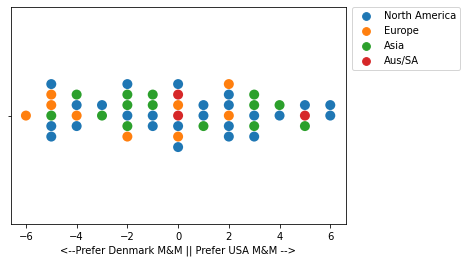

In [554]:
sns.swarmplot(data=pdf, x='mnm_diff',hue='continent_adj',
              size=10,y=[""]*len(pdf))
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

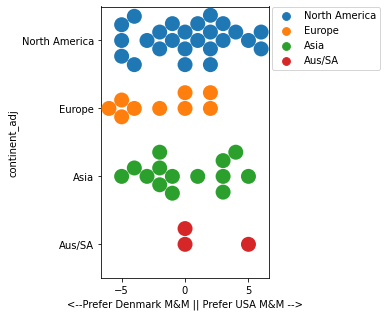

In [555]:
fig = plt.figure(figsize=(3,5))
sns.swarmplot(data=pdf, x='mnm_diff',hue='continent_adj',
              size=15,y='continent_adj')
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

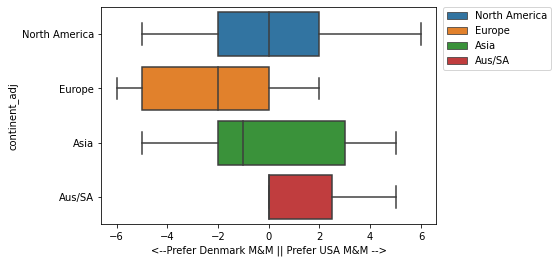

In [556]:
sns.boxplot(data=pdf, x='mnm_diff',y='continent_adj',hue='continent_adj',dodge=False)
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

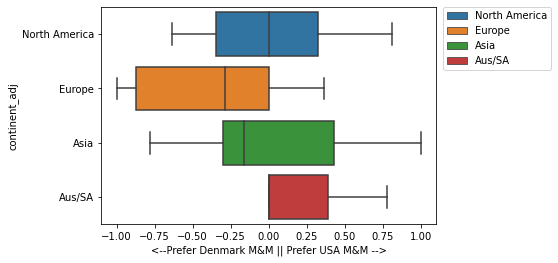

In [557]:
sns.boxplot(data=pdf, x='mnm_ratio',y='continent_adj',hue='continent_adj',dodge=False)
plt.xlabel("<--Prefer Denmark M&M || Prefer USA M&M -->")

plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.show()

In [558]:
lighter_tab10 = []
lighten = 3.7
for x in sns.color_palette("tab10"):
    print('orig:',x)
    lightx = sns.light_palette(x)[2]
    print('new:',lightx)
    lighter_tab10.append(lightx)
    
lighter_tab10 = sns.color_palette(lighter_tab10)
lighter_tab10

orig: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
new: (0.6121039346949929, 0.7530476680842987, 0.8532170068730586)
orig: (1.0, 0.4980392156862745, 0.054901960784313725)
new: (0.9713871486660464, 0.7640327719390043, 0.5849483916608107)
orig: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
new: (0.6225213643910119, 0.8219878478064994, 0.6224676430521614)
orig: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
new: (0.9063080984539633, 0.6260418291993344, 0.6275445674850794)
orig: (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
new: (0.7990828098731056, 0.7271493547150166, 0.8651430051394642)
orig: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
new: (0.7878975533800828, 0.7004382404275995, 0.6827361267749749)
orig: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
new: (0.9257400290000436, 0.751524755314482, 0.8720379078525452)
orig: (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
new: (0.765

[(0.6121039346949929, 0.7530476680842987, 0.8532170068730586),
 (0.9713871486660464, 0.7640327719390043, 0.5849483916608107),
 (0.6225213643910119, 0.8219878478064994, 0.6224676430521614),
 (0.9063080984539633, 0.6260418291993344, 0.6275445674850794),
 (0.7990828098731056, 0.7271493547150166, 0.8651430051394642),
 (0.7878975533800828, 0.7004382404275995, 0.6827361267749749),
 (0.9257400290000436, 0.751524755314482, 0.8720379078525452),
 (0.7652971203642703, 0.7653158978655056, 0.7652422055584429),
 (0.8637741409534866, 0.8659014670566446, 0.5757931206055269),
 (0.5920867224153922, 0.8665751056960371, 0.8958177569731581)]

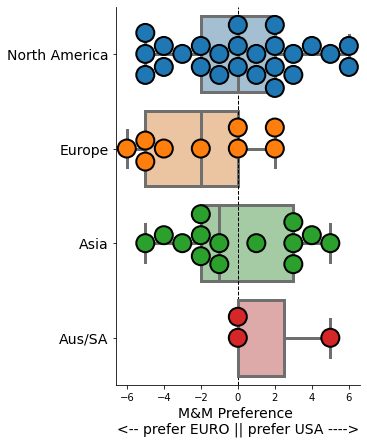

In [626]:
# swarm box overlay
g = sns.catplot(
    data=pdf, x='mnm_diff', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=5/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_diff', y='continent_adj',
                size=18, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_diff.jpg',dpi=200)
plt.show()

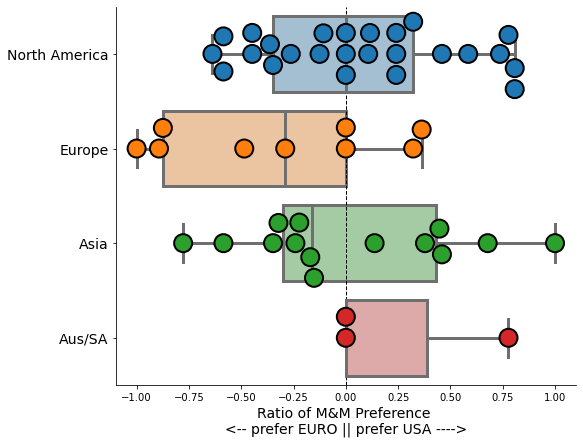

In [625]:
# swarm box overlay
g = sns.catplot(
    data=pdf, x='mnm_ratio', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=8/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_ratio', y='continent_adj',
                size=18, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("Ratio of M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_ratio.jpg',dpi=200)
plt.show()

## Perform t-tests on the preference data
1. For each continent, is the average taste score of the two M&Ms different?
1. For each pair of continents, 

The average doesn't account for some Europeans saying European M&M's are good American M&Ms are normal, vs European M&M's are normal and American M&M's are bad.

Baseline M&M enjoyement might be different, so the ratio of taste scores is perhaps more indicative.

In [561]:
pdf[pdf['continent_adj']=='Europe'][['participant_id','m1_ave','m2_ave','m1_sum','m2_sum','mnm_diff','mnm_ratio']]
#df[df['participant_id'].isin([2,46])].sort_values(['participant_id','mnm_id'])

,participant_id,m1_ave,m2_ave,m1_sum,m2_sum,mnm_diff,mnm_ratio
1,2,1.0,2.0,5,10,-5,-1.000000
3,4,1.8,1.4,9,7,2,0.362570
4,5,1.2,2.2,6,11,-5,-0.874469
7,8,1.4,2.6,7,13,-6,-0.893085
16,17,2.0,1.6,10,8,2,0.321928
23,24,2.0,2.0,10,10,0,0.000000
39,41,2.0,2.0,10,10,0,0.000000
44,46,2.0,2.8,10,14,-4,-0.485427
50,52,1.8,2.2,9,11,-2,-0.289507


In [562]:
eu_m1 = pdf[pdf['continent_adj']=="Europe"]['m1_ave'].values
eu_m2 = pdf[pdf['continent_adj']=="Europe"]['m2_ave'].values

na_m1 = pdf[pdf['continent_adj']=="North America"]['m1_ave'].values
na_m2 = pdf[pdf['continent_adj']=="North America"]['m2_ave'].values

as_m1 = pdf[pdf['continent_adj']=="Asia"]['m1_ave'].values
as_m2 = pdf[pdf['continent_adj']=="Asia"]['m2_ave'].values

sa_m1 = pdf[pdf['continent_adj']=="Aus/SA"]['m1_ave'].values
sa_m2 = pdf[pdf['continent_adj']=="Aus/SA"]['m2_ave'].values

print("__Variances__")
print("Europe")
print(np.var(eu_m1))
print(np.var(eu_m2))

print("North America")
print(np.var(na_m1))
print(np.var(na_m2))

print("Asia")
print(np.var(as_m1))
print(np.var(as_m2))

print("Aus/SA")
print(np.var(sa_m1))
print(np.var(sa_m2))

__Variances__
Europe
0.134320987654321
0.16987654320987655
North America
0.13529599999999997
0.34073599999999993
Asia
0.193469387755102
0.29816326530612247
Aus/SA
0.0622222222222222
0.06222222222222224


Between Europe, North America, and Asia, none of the variances are greater than 4:1, so use equal_var = True

Exclude Aus/SA - too few data points

In [563]:
import scipy.stats as stats

In [564]:
eu_m1_m2_pval = stats.ttest_ind(a=eu_m1, b=eu_m2, equal_var=True)[1]
na_m1_m2_pval = stats.ttest_ind(a=na_m1, b=na_m2, equal_var=True)[1]
as_m1_m2_pval = stats.ttest_ind(a=as_m1, b=as_m2, equal_var=True)[1]

print(f"The p-value for European average taste scores between M1 and M2:{eu_m1_m2_pval:.3f}")
print(f"The p-value for North American average taste scores between M1 and M2:{na_m1_m2_pval:.3f}")
print(f"The p-value for Asian average taste scores between M1 and M2:{as_m1_m2_pval:.3f}")

The p-value for European average taste scores between M1 and M2:0.057
The p-value for North American average taste scores between M1 and M2:0.778
The p-value for Asian average taste scores between M1 and M2:0.942


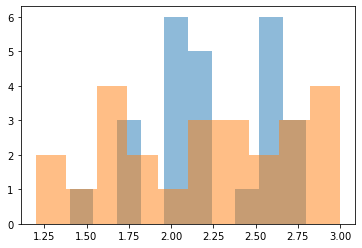

In [565]:
plt.hist(na_m1,alpha=0.5,bins=10)
plt.hist(na_m2,alpha=0.5,bins=10)
plt.show()

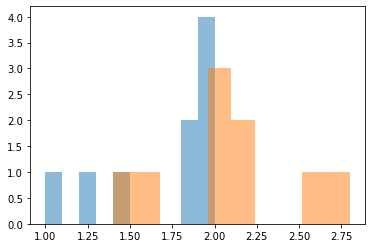

In [566]:
plt.hist(eu_m1,alpha=0.5,bins=10)
plt.hist(eu_m2,alpha=0.5,bins=10)
plt.show()

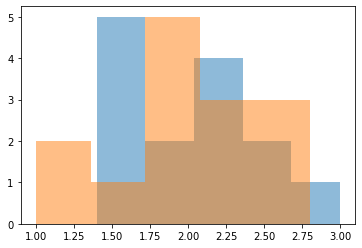

In [567]:
plt.hist(as_m1,alpha=0.5,bins=5)
plt.hist(as_m2,alpha=0.5,bins=5)
plt.show()

In [568]:
eu_na_m1_pval = stats.ttest_ind(a=eu_m1, b=na_m1, equal_var=True)[1]
eu_na_m2_pval = stats.ttest_ind(a=eu_m2, b=na_m2, equal_var=True)[1]

eu_as_m1_pval = stats.ttest_ind(a=eu_m1, b=as_m1, equal_var=True)[1]
eu_as_m2_pval = stats.ttest_ind(a=eu_m2, b=as_m2, equal_var=True)[1]

as_na_m1_pval = stats.ttest_ind(a=as_m1, b=na_m1, equal_var=True)[1]
as_na_m2_pval = stats.ttest_ind(a=as_m2, b=na_m2, equal_var=True)[1]

print(f"The p-value for European vs North American average taste scores for M1:{eu_na_m1_pval:.3f}")
print(f"The p-value for European vs North American average taste scores for M2:{eu_na_m2_pval:.3f}")
print()

print(f"The p-value for European vs Asian average taste scores for M1:{eu_as_m1_pval:.3f}")
print(f"The p-value for European vs Asian average taste scores for M2:{eu_as_m2_pval:.3f}")
print()

print(f"The p-value for North American vs Asian average taste scores for M1:{as_na_m1_pval:.3f}")
print(f"The p-value for North American vs Asian average taste scores for M2:{as_na_m2_pval:.3f}")

The p-value for European vs North American average taste scores for M1:0.001
The p-value for European vs North American average taste scores for M2:0.588

The p-value for European vs Asian average taste scores for M1:0.080
The p-value for European vs Asian average taste scores for M2:0.838

The p-value for North American vs Asian average taste scores for M1:0.114
The p-value for North American vs Asian average taste scores for M2:0.404


<Axes: xlabel='mnm_ratio', ylabel='Density'>

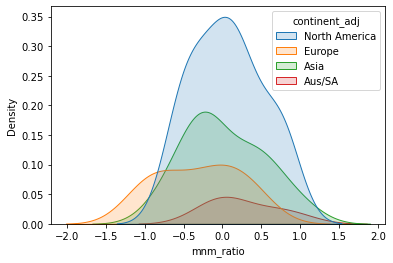

In [569]:
sns.kdeplot(data=pdf,x='mnm_ratio',hue='continent_adj',
           fill=True,alpha=0.2)


<Axes: xlabel='m1_ave', ylabel='Density'>

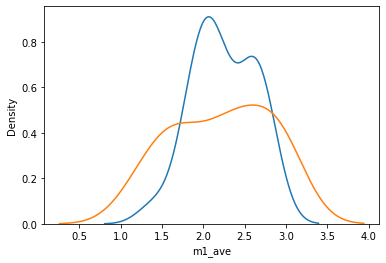

In [570]:
sns.kdeplot(data=pdf[pdf['continent_adj']=="North America"]['m1_ave'])
sns.kdeplot(data=pdf[pdf['continent_adj']=="North America"]['m2_ave'])

<Axes: xlabel='m1_ave', ylabel='Density'>

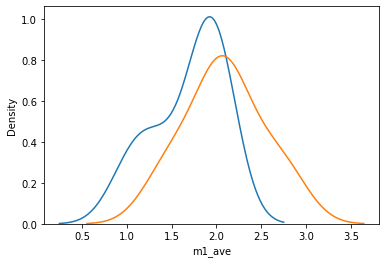

In [571]:
sns.kdeplot(data=pdf[pdf['continent_adj']=="Europe"]['m1_ave'])
sns.kdeplot(data=pdf[pdf['continent_adj']=="Europe"]['m2_ave'])

In [572]:
colors = sns.color_palette('tab10')

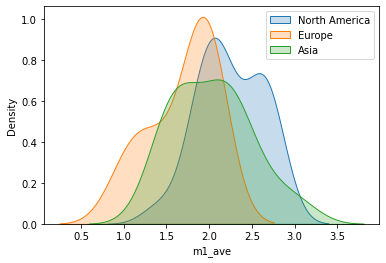

In [573]:
sns.kdeplot(x=pdf[pdf['continent_adj']=="North America"]['m1_ave'],
            fill=True,label='North America')
sns.kdeplot(x=pdf[pdf['continent_adj']=="Europe"]['m1_ave'],
            fill=True,label='Europe')
sns.kdeplot(x=pdf[pdf['continent_adj']=="Asia"]['m1_ave'],
            fill=True,label='Asia')

plt.legend()

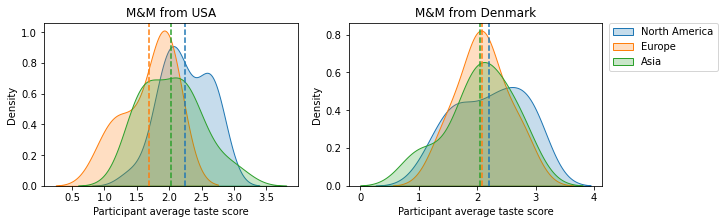

In [618]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,3))

# Left plot
sns.kdeplot(x=pdf[pdf['continent_adj']=="North America"]['m1_ave'],
            fill=True,ax=ax1,label='North America')
sns.kdeplot(x=pdf[pdf['continent_adj']=="Europe"]['m1_ave'],
            fill=True,ax=ax1,label='Europe')
sns.kdeplot(x=pdf[pdf['continent_adj']=="Asia"]['m1_ave'],
            fill=True,ax=ax1,label='Asia')

ax1.axvline(np.mean(na_m1),c=colors[0],linestyle='--')
ax1.axvline(np.mean(eu_m1),c=colors[1],linestyle='--')
ax1.axvline(np.mean(as_m1),c=colors[2],linestyle='--')

ax1.set_title("M&M from USA")
ax1.set_xlabel("Participant average taste score")
# Right plot
sns.kdeplot(data=pdf[pdf['continent_adj']=="North America"]['m2_ave'],
            fill=True,ax=ax2)
sns.kdeplot(data=pdf[pdf['continent_adj']=="Europe"]['m2_ave'],
            fill=True,ax=ax2)
sns.kdeplot(data=pdf[pdf['continent_adj']=="Asia"]['m2_ave'],
            fill=True,ax=ax2)

ax2.axvline(np.mean(na_m2),c=colors[0],linestyle='--')
ax2.axvline(np.mean(eu_m2),c=colors[1],linestyle='--')
ax2.axvline(np.mean(as_m2),c=colors[2],linestyle='--')

ax2.set_title("M&M from Denmark")
ax2.set_xlabel("Participant average taste score")

fig.legend(bbox_to_anchor=(0.91, 0.88), loc='upper left', borderaxespad=0)
fig.savefig('figs/mnm_kde_ave_score.jpg',dpi=200)



#sns.kdeplot(data=pdf[pdf['continent_adj'].isin(["Europe","North America"])],x='mnm_ratio',hue='continent_adj')

## Ratio version of scores

In [575]:
eu_ratio = pdf[pdf['continent_adj']=="Europe"]['mnm_ratio'].values
na_ratio = pdf[pdf['continent_adj']=="North America"]['mnm_ratio'].values

eu_na_ratio_pval = stats.ttest_ind(a=eu_ratio, b=na_ratio, equal_var=True)[1]
print(f"The p-value for European vs North American ratios:{eu_na_ratio_pval:.3f}")


The p-value for European vs North American ratios:0.049


In [576]:
print(eu_ratio)
stats.ttest_1samp(eu_ratio, popmean=0.0)

[-1.          0.36257008 -0.87446912 -0.8930848   0.32192809  0.
  0.         -0.48542683 -0.28950662]


TtestResult(statistic=-1.8128386527594693, pvalue=0.10742308942195414, df=8)

In [577]:
print(na_ratio)
stats.ttest_1samp(na_ratio, popmean=0.0)

[-0.36257008  0.         -0.26303441  0.          0.         -0.3479233
 -0.12553088 -0.44745898 -0.5849625   0.32192809  0.80735492 -0.5849625
  0.2410081   0.2410081  -0.44745898  0.2410081   0.73696559  0.11547722
  0.77760758  0.80735492  0.5849625  -0.63742992 -0.1069152   0.45943162
  0.1069152 ]


TtestResult(statistic=0.6680718447877968, pvalue=0.5104620596169753, df=24)

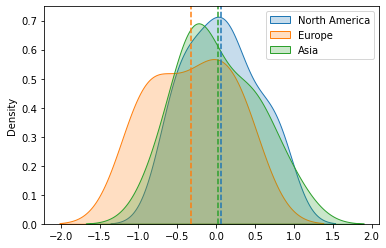

In [578]:
na_ratios = pdf[pdf['continent_adj']=="North America"]['mnm_ratio'].values
eu_ratios = pdf[pdf['continent_adj']=="Europe"]['mnm_ratio'].values
as_ratios = pdf[pdf['continent_adj']=="Asia"]['mnm_ratio'].values

sns.kdeplot(x=na_ratios,fill=True,label='North America')
sns.kdeplot(x=eu_ratios,fill=True,label='Europe')
sns.kdeplot(x=as_ratios,fill=True,label='Asia')
# sns.kdeplot(x=pdf[pdf['continent_adj']=="Aus/SA"]['mnm_ratio'],
#             fill=True,label='Aus/SA')

plt.axvline(np.mean(na_ratios),c=colors[0],linestyle='--')
plt.axvline(np.mean(eu_ratios),c=colors[1],linestyle='--')
plt.axvline(np.mean(as_ratios),c=colors[2],linestyle='--')


plt.legend()


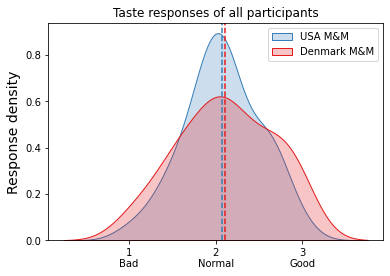

In [633]:
fig,ax = plt.subplots()
color_origin = sns.color_palette('Set1')
m1_aves = pdf['m1_ave'].values
m2_aves = pdf['m2_ave'].values

sns.kdeplot(x=m1_aves,fill=True,label='USA M&M',color=color_origin[1])
sns.kdeplot(x=m2_aves,fill=True,label='Denmark M&M',color=color_origin[0])

plt.axvline(np.mean(m1_aves),c=color_origin[1],linestyle='--')
plt.axvline(np.mean(m2_aves),c=color_origin[0],linestyle='--')

plt.xticks([1,2,3])
labels = ['1\nBad', '2\nNormal','3\nGood']
ax.set_xticklabels(labels)
plt.ylabel("Response density",fontsize=14)
plt.title("Taste responses of all participants")
plt.legend()
fig.savefig('figs/all_data_response_density.jpg',dpi=200)


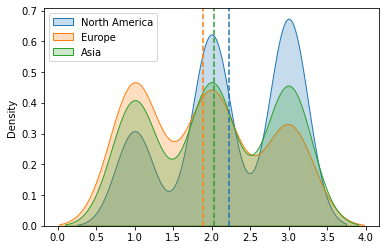

In [591]:
na_scores = df[df['continent_adj']=="North America"]['taste_score'].values
eu_scores = df[df['continent_adj']=="Europe"]['taste_score'].values
as_scores = df[df['continent_adj']=="Asia"]['taste_score'].values

sns.kdeplot(x=na_scores,fill=True,label='North America')
sns.kdeplot(x=eu_scores,fill=True,label='Europe')
sns.kdeplot(x=as_scores,fill=True,label='Asia')
# sns.kdeplot(x=pdf[pdf['continent_adj']=="Aus/SA"]['mnm_ratio'],
#             fill=True,label='Aus/SA')

plt.axvline(np.mean(na_scores),c=colors[0],linestyle='--')
plt.axvline(np.mean(eu_scores),c=colors[1],linestyle='--')
plt.axvline(np.mean(as_scores),c=colors[2],linestyle='--')


plt.legend(loc='upper left')

In [592]:
df

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin,continent_adj,taste_score
0,1,2,green,normal,,North America,Denmark,North America,2
1,1,1,orange,bad,,North America,USA,North America,1
2,1,1,blue,normal,,North America,USA,North America,2
3,1,2,brown,normal,,North America,Denmark,North America,2
4,1,1,yellow,bad,,North America,USA,North America,1
...,...,...,...,...,...,...,...,...,...
505,52,1,red,good,,Europe,USA,Europe,3
506,52,2,red,bad,,Europe,Denmark,Europe,1
507,52,1,brown,bad,,Europe,USA,Europe,1
508,52,2,brown,good,,Europe,Denmark,Europe,3


<Axes: xlabel='mnm_diff', ylabel='mnm_ratio'>

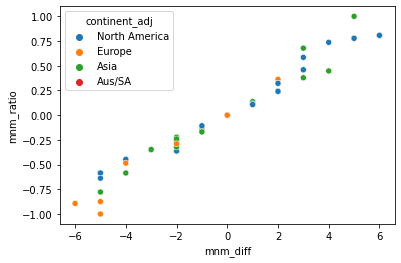

In [582]:
sns.scatterplot(data=pdf,x='mnm_diff',y='mnm_ratio',hue='continent_adj')

In [266]:
pdf[pdf['continent_adj']=="Europe"][['participant_id','continent_adj','m1_sum','m1_ave','m2_sum','m2_ave','mnm_diff','mnm_ratio']]

,participant_id,continent_adj,m1_sum,m1_ave,m2_sum,m2_ave,mnm_diff,mnm_ratio
1,2,Europe,5,1.0,10,2.0,-5,-1.000000
3,4,Europe,9,1.8,7,1.4,2,0.362570
4,5,Europe,6,1.2,11,2.2,-5,-0.874469
7,8,Europe,7,1.4,13,2.6,-6,-0.893085
16,17,Europe,10,2.0,8,1.6,2,0.321928
23,24,Europe,10,2.0,10,2.0,0,0.000000
39,41,Europe,10,2.0,10,2.0,0,0.000000
44,46,Europe,10,2.0,14,2.8,-4,-0.485427
50,52,Europe,9,1.8,11,2.2,-2,-0.289507


In [223]:
df[df['participant_id'].isin([17])].sort_values('mnm_origin')

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin,continent_adj,taste_score
160,17,2,green,normal,,Europe,Denmark,Europe,2
163,17,2,yellow,bad,,Europe,Denmark,Europe,1
164,17,2,red,normal,,Europe,Denmark,Europe,2
165,17,2,brown,bad,,Europe,Denmark,Europe,1
167,17,2,green,normal,,Europe,Denmark,Europe,2
161,17,1,blue,good,,Europe,USA,Europe,3
162,17,1,brown,normal,,Europe,USA,Europe,2
166,17,1,green,good,,Europe,USA,Europe,3
168,17,1,red,bad,,Europe,USA,Europe,1
169,17,1,orange,bad,REALLY bad,Europe,USA,Europe,1


What number should I focus on to highlight participant preference?
* The "skew": how much a participant leans USA vs Den, based on sum of responses - more positive is USA
* The "ratio": log2 of USA sum/Den sum - more positive is USA
* the "average": average of taste scores? Would this be meaningfully different than the sum?

Also, consider the variability of individual participants - ave std of responses? 0 is highly consistent

Can I now do a t-test for difference in M&M preference because it's now a distribution?


** Make sure you understand why the ratio version is more intense than the skew?

## Do the results change if you chop off the first 4 of each participant?
Maybe they gained clarity after tasting at least 1 of each type

In [267]:
df_chop4 = pd.DataFrame()
for g,d in dfp:
    df_chop4 = pd.concat([df_chop4,d.tail(6)])
    
df_chop4.head(14)

,participant_id,mnm_id,mnm_color,taste_response,notes,continent,mnm_origin,continent_adj,taste_score
4,1,1,yellow,bad,,North America,USA,North America,1
5,1,2,red,good,very diffferent than any previous,North America,Denmark,North America,3
6,1,2,yellow,bad,,North America,Denmark,North America,1
7,1,1,red,normal,,North America,USA,North America,2
8,1,1,brown,bad,,North America,USA,North America,1
9,1,2,blue,bad,,North America,Denmark,North America,1
14,2,2,red,normal,,Europe,Denmark,Europe,2
15,2,1,green,bad,,Europe,USA,Europe,1
16,2,2,brown,normal,,Europe,Denmark,Europe,2
17,2,2,orange,normal,,Europe,Denmark,Europe,2


In [268]:

alt.Chart(df_chop4).mark_bar(size=90).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",axis=alt.Axis(labelAngle=0)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending')
).properties(width=210)

alt.Chart(...)

In [269]:
alt.Chart(df_chop4).mark_bar(size=40).encode(
    x=alt.X('mnm_origin:N',title="M&M origin",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=taste_order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('continent_adj:N',title='',header=alt.Header(labelFontSize=18),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(
    width=100,
    height=180
)

alt.Chart(...)

In [270]:
df_chop4_filt = df_chop4[df_chop4['continent_adj'] != 'Aus/SA']
order = ['bad','normal','good']

alt.Chart(df_chop4_filt).mark_bar(size=70).encode(
    x=alt.X('continent_adj:N',title="Participant continent",axis=alt.Axis(labelAngle=0,labelFontSize=10)),
    y=alt.Y('count(taste_response)',title="Percent of Responses").stack('normalize'),
    color=alt.Color('taste_response:N',sort=order,title="Taste").scale(scheme='brownbluegreen'),
    order=alt.Order('color_taste_response_sort_index:Q',sort='descending'),
    column=alt.Column('mnm_origin:N',title='M&M Origin',
                      header=alt.Header(labelFontSize=18,titleFontSize=14),sort='descending'),
    tooltip=['continent_adj','taste_response','mnm_origin','count(taste_response)']
).properties(width=250, height=200)

alt.Chart(...)

In [271]:
w = 60
h = 80

eu = alt.Chart(df_chop4[df_chop4['continent_adj']=='Europe'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',sort=order,axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N",title='M&M Origin'),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='Europe',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

na = alt.Chart(df_chop4[df_chop4['continent_adj']=='North America'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",sort=order,title='',axis=alt.Axis(labels=False)),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='North America',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

asi = alt.Chart(df_chop4[df_chop4['continent_adj']=='Asia'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",sort=order,title=''),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='Asia',titleFontSize=20)),
).properties(
    width=w,
    height=h,
)

ausa = alt.Chart(df_chop4[df_chop4['continent_adj']=='Aus/SA'],).mark_bar(size=30).encode(
    alt.Y("count(taste_response):N",title="Count"),
    alt.X("mnm_origin",title='',),
    alt.Color("mnm_origin:N"),
    alt.Column("taste_response:N",sort=order,spacing=2,
               header=alt.Header(labelFontSize=14,title='Aus/SA',titleFontSize=20)),
    order=alt.Order('column_taste_response_sort_index:Q')
).properties(
    width=w,
    height=h,
)

euna = alt.hconcat(eu,na)
aa = alt.hconcat(asi,ausa)
alt.vconcat(euna,aa
).configure_axis(
    grid=False,
)

alt.VConcatChart(...)

In [272]:
dfp_chop4 = df_chop4.groupby('participant_id')


In [273]:
p_score_data_chop4 = []
for p in dfp_chop4.groups:
    p_df = dfp_chop4.get_group(p)
    
    m1_vals = p_df[p_df['mnm_id']==1]['taste_score'].values
    m1_sum = sum(m1_vals)
    m1_ave = np.mean(m1_vals)
    m1_std = np.std(m1_vals)
    
    m2_vals = p_df[p_df['mnm_id']==2]['taste_score'].values
    m2_sum = sum(m2_vals)
    m2_ave = np.mean(m2_vals)
    m2_std = np.std(m2_vals)
    
    row = [p,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std]
    p_score_data_chop4.append(row)

p_score_df_chop4 = pd.DataFrame(p_score_data_chop4, columns=[
    'participant_id',
    'm1_sum',
    'm1_ave',
    'm1_std',
    'm2_sum',
    'm2_ave',
    'm2_std'
])

pdf_chop4 = pd.merge(
    p_score_df_chop4,
    participants,
    how="inner",
    on='participant_id')
pdf_chop4.head()

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj
0,1,4,1.333333,0.471405,5,1.666667,0.942809,North America,collected in Lyngby,North America
1,2,3,1.000000,0.000000,6,2.000000,0.000000,Europe,collected in Lyngby,Europe
2,3,7,2.333333,0.942809,5,1.666667,0.942809,North America,collected in Lyngby,North America
3,4,3,1.500000,0.500000,6,1.500000,0.500000,Europe,collected in Lyngby,Europe
4,5,4,1.000000,0.000000,4,2.000000,0.000000,Europe,collected in Lyngby,Europe


In [275]:
pdf_chop4['mnm_diff'] = pdf_chop4.apply(lambda row: row['m1_sum'] - row['m2_sum'],axis=1)
pdf_chop4['mnm_ratio'] = pdf_chop4.apply(lambda row: np.log2(row['m1_ave']/row['m2_ave']),axis=1)
pdf_chop4['ave_std'] = pdf_chop4.apply(lambda row: np.mean([row['m1_std'], row['m2_std']]),axis=1)
pdf_chop4

,participant_id,m1_sum,m1_ave,m1_std,m2_sum,m2_ave,m2_std,continent_of_origin,data_collection,continent_adj,mnm_skew,mnm_ratio,ave_std,mnm_diff
0,1,4,1.333333,0.471405,5,1.666667,0.942809,North America,collected in Lyngby,North America,-1,-0.321928,0.707107,-1
1,2,3,1.000000,0.000000,6,2.000000,0.000000,Europe,collected in Lyngby,Europe,-3,-1.000000,0.000000,-3
2,3,7,2.333333,0.942809,5,1.666667,0.942809,North America,collected in Lyngby,North America,2,0.485427,0.942809,2
3,4,3,1.500000,0.500000,6,1.500000,0.500000,Europe,collected in Lyngby,Europe,-3,0.000000,0.500000,-3
4,5,4,1.000000,0.000000,4,2.000000,0.000000,Europe,collected in Lyngby,Europe,0,-1.000000,0.000000,0
5,6,5,2.500000,0.500000,10,2.500000,0.500000,North America,collected in Lyngby,North America,-5,0.000000,0.500000,-5
6,7,7,1.750000,0.433013,3,1.500000,0.500000,North America,collected in Lyngby,North America,4,0.222392,0.466506,4
7,8,4,1.333333,0.471405,9,3.000000,0.000000,Europe,collected in Lyngby,Europe,-5,-1.169925,0.235702,-5
8,9,6,3.000000,0.000000,6,1.500000,0.500000,Australia,collected in Lyngby,Aus/SA,0,1.000000,0.250000,0
9,10,9,3.000000,0.000000,7,2.333333,0.471405,North America,collected in Lyngby,North America,2,0.362570,0.235702,2


/Users/erinwilson/miniconda3/envs/pytu_prac/lib/python3.11/site-packages/seaborn/categorical.py:1296: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


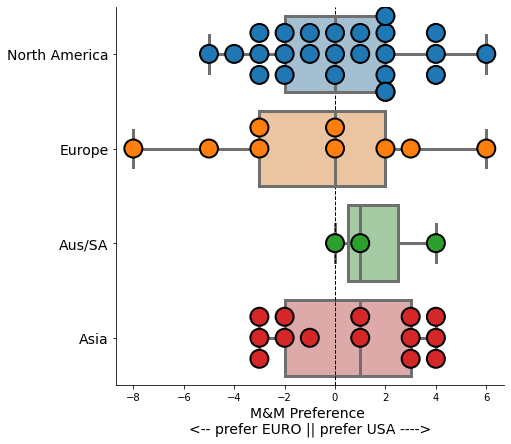

In [623]:
# swarm box overlay
g = sns.catplot(
    data=pdf_chop4, x='mnm_diff', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=7/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_diff', y='continent_adj',
                size=18, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_diff_chop4.jpg',dpi=200)
plt.show()

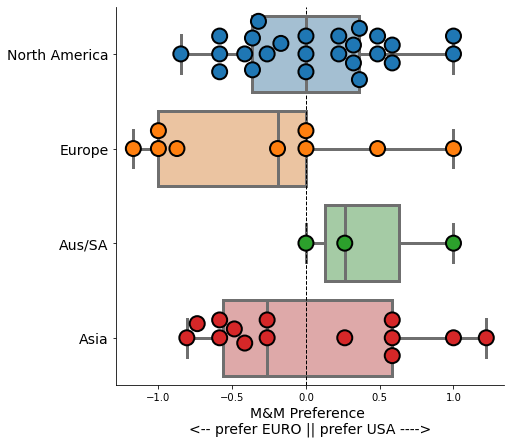

In [624]:
# swarm box overlay
g = sns.catplot(
    data=pdf_chop4, x='mnm_ratio', y='continent_adj',
    kind='box',palette=lighter_tab10,
    boxprops=dict(alpha=1),height=6,aspect=7/6,linewidth=3,
)
g.map_dataframe(sns.swarmplot, x='mnm_ratio', y='continent_adj',
                size=15, #alpha=0.99,
                edgecolor='black',linewidth=2, dodge=True,
                palette='tab10',
               )

plt.axvline(0,color='black',linestyle='--',linewidth=1)
plt.xlabel("M&M Preference \n<-- prefer EURO || prefer USA ---->",fontsize=14)
plt.ylabel("")
plt.yticks(fontsize=14)
g.savefig('figs/mnm_pref_box_swarm_ratio_chop4.jpg',dpi=200)
plt.show()